<a href="https://colab.research.google.com/github/kebabee/Modelowanie-komputerowe/blob/main/clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eden's model
A simple growth model. Simulation starts with one living cell on square grid, update algorithm:
* Randomly pick one of living cells
* Randomly pick one of free spots around this cells (up, down, left, right)
* Add new living cell in this point

When all of 4 spots around living cell are full, then this cells dies and new growth from it is not possible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def eden_step():
    curr_cell = alive_cells[np.random.randint(len(alive_cells))] # randowmy pick living cell
    curr_x = curr_cell[0]
    curr_y = curr_cell[1]
    new_positions = [[curr_x+1, curr_y],[curr_x-1, curr_y],[curr_x, curr_y+1],[curr_x, curr_y-1]] # possible points around cell

    for _ in range(100):
        temp = new_positions[np.random.randint(0,4)]
        if arr[temp[0]][temp[1]] == 0: # if point is free
            alive_cells.append(temp)   # add new living cell
            arr[temp[0]][temp[1]] = 1
            break

    for ac in alive_cells: # chech if any of living cell should die
        if arr[ac[0]-1][ac[1]] != 0 and arr[ac[0]+1][ac[1]] != 0 and arr[ac[0]][ac[1]+1] != 0 and arr[ac[0]-1][ac[1]-1] != 0:
            alive_cells.remove(ac)
            graveyard.append(ac)
            arr[ac[0]][ac[1]] = -1

Visual:

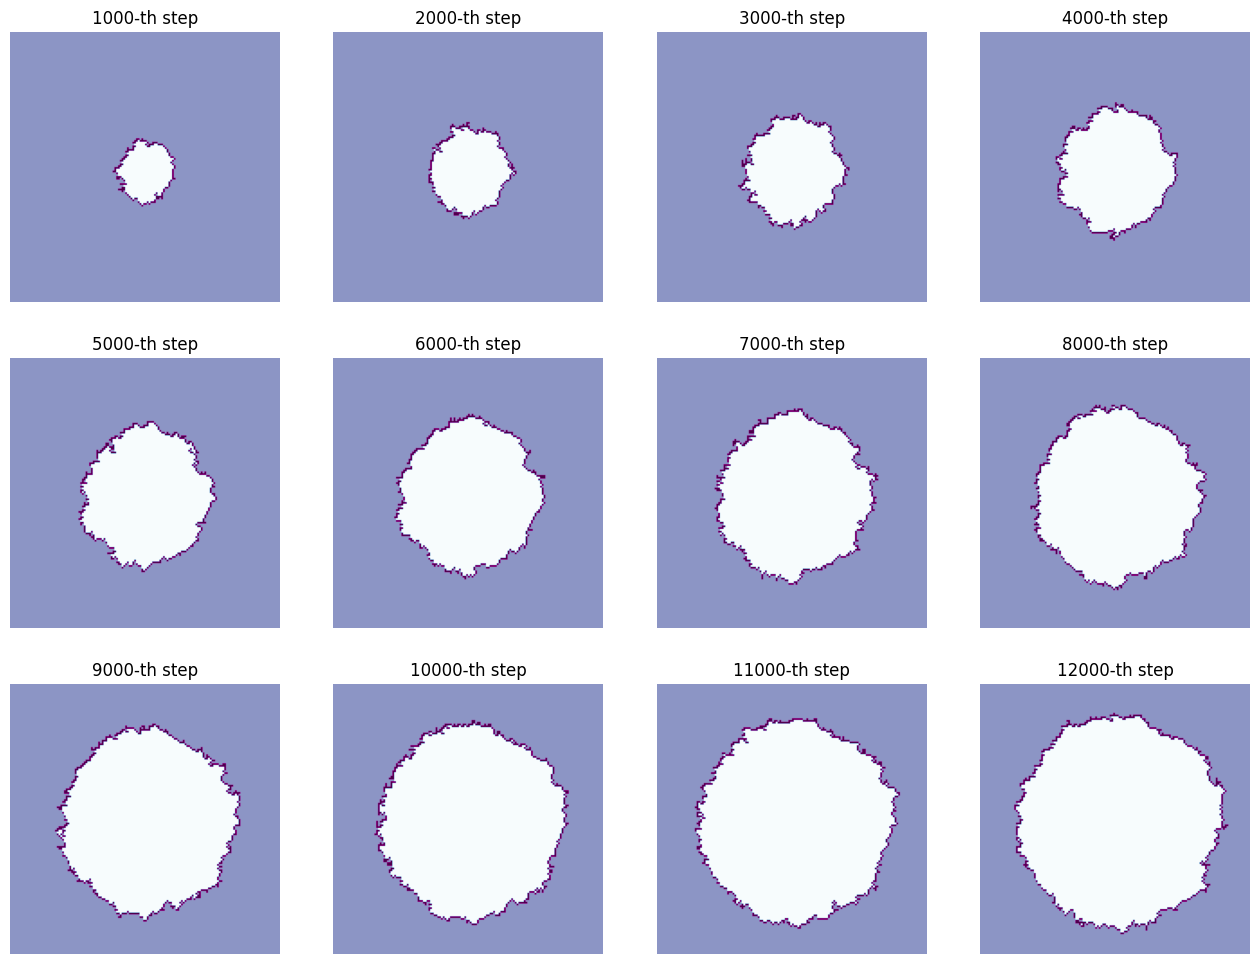

In [3]:
size = 150
arr = np.zeros((size,size)) # actual state of model
alive_cells = [[size//2,size//2]] # array for living cells
arr[size//2][size//2] = 1
graveyard = [] # array for dead cells

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i in range(12):
    for _ in range(1000):
        eden_step()
    col, row = i % 4, i // 4
    axes[row, col].imshow(arr, cmap="BuPu")
    axes[row, col].set_title(f"{(i+1)*1000}-th step")
    axes[row, col].axis('off')
plt.show()

### 1.1 Radius and number of cells

I define cluster radius as distance from starting point to farest living cell.
$$R = \sqrt{(x_0 - x_{cell})^2 + (y_0 - y_{cell})^2}$$

Growth of 5000 cells in 10 models:

In [4]:
def cluster_R(center):
    max_R = 0

    for ac in alive_cells:
        R = np.sqrt((center - ac[0]) ** 2 + (center - ac[1]) ** 2)

        if R > max_R:
            max_R = R
    return max_R



size = 1000
Rs = []

for i in range(10):
    arr = np.zeros((size,size))
    alive_cells = [[size//2,size//2]]
    arr[size//2][size//2] = 1
    graveyard = []
    tempR = []
    tempN = []
    for _ in range(5000):
        eden_step()
        tempR.append(cluster_R(size//2))
        tempN.append(np.sqrt(len(alive_cells) + len(graveyard)))
    Rs.append(tempR)

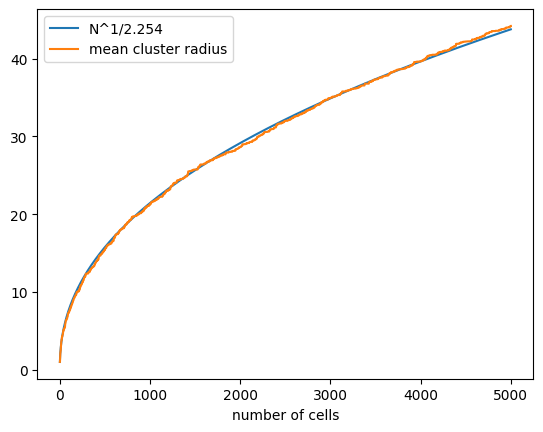

In [5]:
from scipy.optimize import curve_fit

def f(x, a): # function to fit
    return x**(1/a)

R_mean = np.mean(Rs, axis=0) # mean of radiuses

N = np.linspace(1,len(R_mean),len(R_mean))
popt, pcov = curve_fit(f, N, R_mean)

N_fit = [n ** (1/popt[0]) for n in N]

plt.plot(np.linspace(1,len(N_fit),len(N_fit)), N_fit, label=f'N^1/{popt[0]:.3f}')
plt.plot(np.linspace(1,len(R_mean),len(R_mean)), R_mean, label='mean cluster radius')
plt.xlabel('number of cells')
plt.legend()
plt.show()

For analized models, mean radius is proportional to $N^{1/2.25}$.

## 2. DLA
Diffusion-Limited Aggregation is another clusters growth model. Simulation starts with one living cell, new cells randomly walk untill they find living cell. Then new cell "sticks" to found living cell. Algorithm:
* Randomly pick new particle position
* Random walk
* Stop if cluster was found

In my code starting position for new cell is randomly picked from square surrounding cluster. If new 'sticked' cell is close to this square, then it is expanded.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random

steps = [[0, 1], [0, -1], [1, 0], [-1, 0]] # steps in random walk

def new_particle():
    global border
    if border <= 3:
        border_width = 3
    else:
        border_width = int(border)

    edge = np.random.randint(0,4) # randomly pick edge of surrounding square

    if edge == 0: # on left
        pos = [border_width, np.random.randint(border_width, size - border_width)]
    elif edge == 1: # on top
        pos = [np.random.randint(border_width, size - border_width), border_width]
    elif edge == 2: # on roght
        pos = [size - border_width, np.random.randint(border_width, size - border_width)]
    elif edge == 3: # on bottom
        pos = [np.random.randint(border_width, size - border_width), size - border_width]

    while True:
        step = random.choice(steps)
        pos = (pos[0] + step[0], pos[1] + step[1])

        # if cell walked to boundary, try again
        if pos[0] < 1 or pos[0] >= size - 2 or pos[1] < 1 or pos[1] >= size - 2:
            edge = np.random.randint(0,4)
            if edge == 0: # po lewej
                pos = [border_width, np.random.randint(border_width, size - border_width)]
            elif edge == 1: # na górze
                pos = [np.random.randint(border_width, size - border_width), border_width]
            elif edge == 2: # po prawej
                pos = [size - border_width, np.random.randint(border_width, size - border_width)]
            elif edge == 3: # na dole
                pos = [np.random.randint(border_width, size - border_width), size - border_width]

        # did cell found cluster?
        elif ( arr[(pos[0], pos[1])] == 1 or arr[(pos[0] + 1, pos[1])] == 1
                or arr[(pos[0] - 1, pos[1])] == 1 or arr[(pos[0], pos[1] + 1)] == 1
                or arr[(pos[0], pos[1] - 1)] ):
            # add to cluster
            arr[pos] = 1

            # is sticked cell close to surrounding square?
            if (pos[0] == border_width + 5 or pos[0] == size - border_width - 5
               or pos[1] == border_width + 5 or pos[1] == size - border_width - 5):
                border -= 3 # expand surrounding square

            break

Wizualizacja przyrostu klastra:

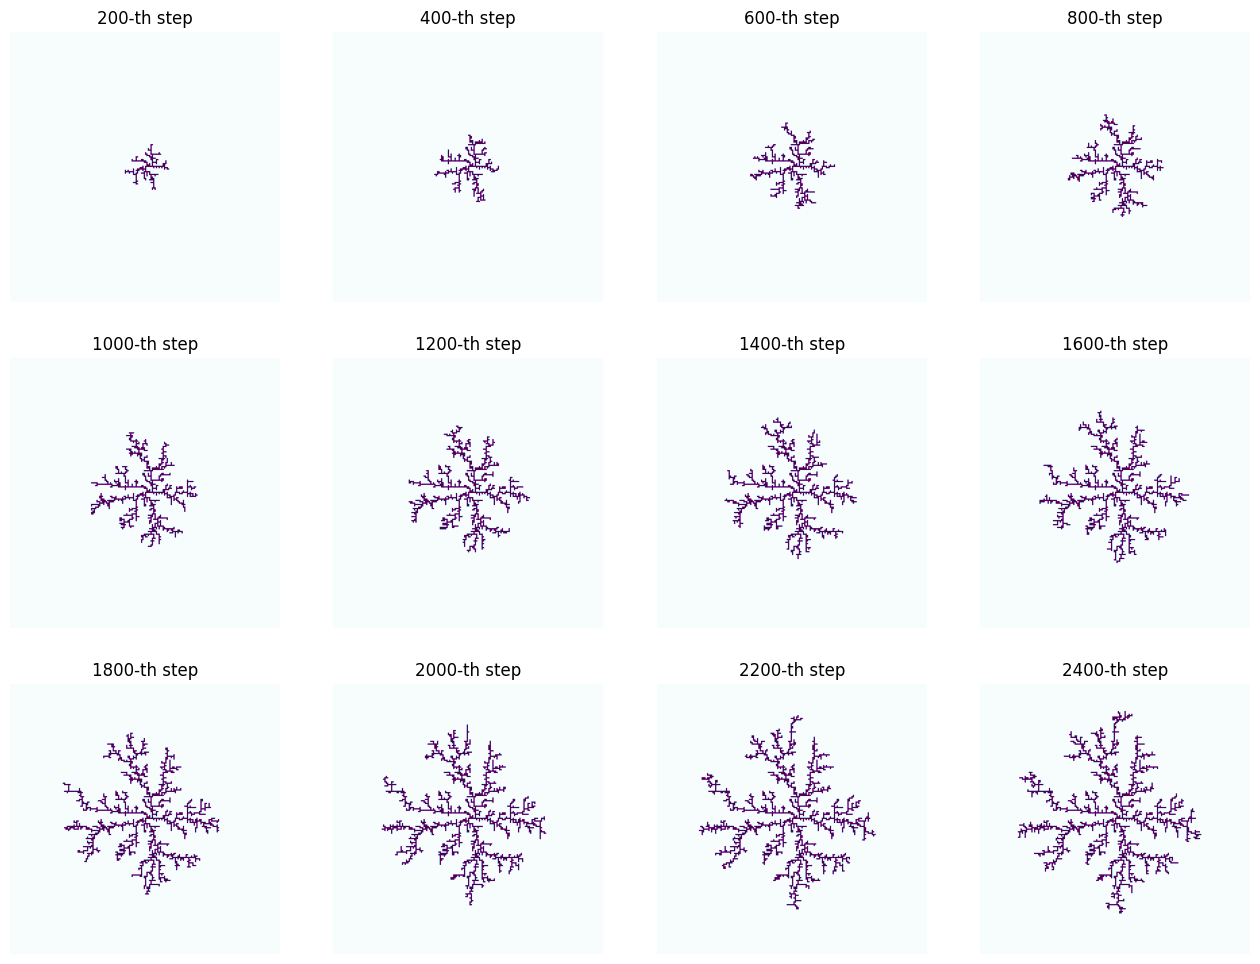

In [9]:
size = 200  # size of grid
border = 85  # distance from boundary to surrounding square
arr = np.zeros([size, size])
arr[size//2][size//2] = 1

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i in range(12):
    for _ in range(200):
        new_particle()
    col, row = i % 4, i // 4
    axes[row, col].imshow(arr, cmap="BuPu")
    axes[row, col].set_title(f"{(i+1)*200}-th step")
    axes[row, col].axis('off')
plt.show()

### 2.2 Liczba komórek a promień klastra

Promień klastra definiuję w taki sam sposób jak dla modelu Edena. Uruchamiam 5 modeli, w każdym wykonuje się przyrost 1000 komórek.

In [11]:
size = 300
border = 135
arr = np.zeros([size, size])
arr[size//2][size//2] = 1
Rs = []

for _ in range(5):
    temp = []
    arr = np.zeros([size, size])
    arr[size//2][size//2] = 1
    for i in range(1000):
        new_particle()

        # find radius of cluster
        center = np.array([size // 2, size // 2])
        points = np.array(np.where(arr == 1)).T  # indexes of all cells = 1
        distances = np.linalg.norm(points - center, axis=1)  # radiuses

        temp.append(np.max(distances))  # max distance = radius
    Rs.append(temp)

R_mean = np.mean(Rs, axis=0)

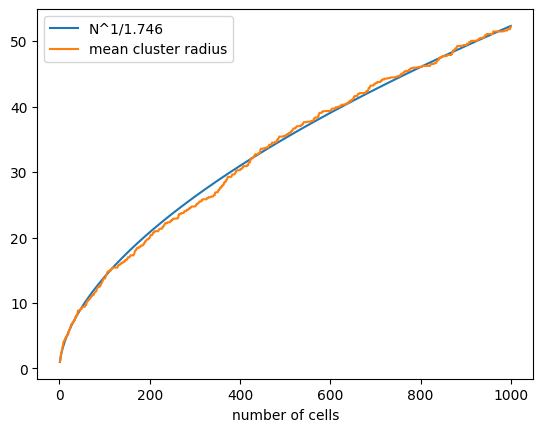

In [12]:
N = np.linspace(1,len(R_mean),len(R_mean))
popt, pcov = curve_fit(f, N, R_mean)

N_fit = [n ** (1/popt[0]) for n in N]

plt.plot(np.linspace(1,len(N_fit),len(N_fit)), N_fit, label=f'N^1/{popt[0]:.3f}')
plt.plot(np.linspace(1,len(R_mean),len(R_mean)), R_mean, label='mean cluster radius')
plt.xlabel('number of cells')
plt.legend()
plt.show()

For analyzed models mean darius is proportional to $N^{1/1.75}$.

# 3. Snowflakes

At the begining I have to simulate triangular grid on 2 dimensional array. Neighbourhood of point in this kind of grid is given by:
* array[x-1,y]
* array[x+1,y]
* array[x,y-1]
* array[x,y+1]
* array[x-1,y-1]
* array[x+1,y+1]

Snowflake model is cellular automaton. If dead cell have 1 living (frozen) neighbour, then it becomes living in next epoch.

In [13]:
def count_neighbors(grid, x, y):
    neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1), (x-1, y-1), (x+1, y+1)] # triangular neighbourhood
    count = 0
    for neighbor in neighbors:
        nx, ny = neighbor
        if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[0] and grid[nx, ny] == 1:
            count += 1
    return count

def snowflake(grid, num):
    temp_grid = np.copy(grid)
    for x in range(grid.shape[0]):
        for y in range(grid.shape[0]):
            if grid[x, y] == 0 and count_neighbors(grid, x, y) == num:
                temp_grid[x, y] = 1
    return temp_grid

Starting point is one frozen cell in array center. Example of snowflake:

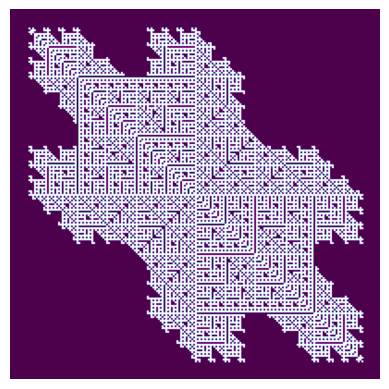

In [14]:
size = 200

grid = np.zeros((size,size))
grid[size//2,size//2] = 1

for _ in range(90):
    grid = snowflake(grid, 1)

plt.imshow((-1)*grid, cmap="BuPu")
plt.axis('off')
plt.show()

In order to visualize triangular grid in 2d array I implemented "rescale" function:
* “Stretch” the array horizontally, each original pixel will occur twice.
* Move the pixels in each row to the right by (number of rows - row number) pixels.
* Stretch the array vertically, each row will occur twice.
* Center the snowflake.

In this way, the original two-dimensional array was transformed into an array twice its size with values arranged as on a triangular grid.

In [15]:
def rescale(grid):
    # stretch horizontally
    temp1 = []
    for i in range(grid.shape[0]):
        temp = []
        for j in range(grid.shape[0]):
            temp.append(grid[i,j])
            temp.append(grid[i,j])
        temp1.append(temp)

    # move pixels
    temp2 = []
    for i in range(len(temp1)):
        temp2.append(temp1[i][-(len(temp1)-i):] + temp1[i][:-(len(temp1)-i)])

    # stretch vertically
    temp3 = []
    for i in range(len(temp2)):
        temp3.append(temp2[i])
        temp3.append(temp2[i])

    # center snowflake
    temp4 = []
    for i in range(len(temp3)):
        temp4.append(temp3[i][-3*len(temp3)//4:] + temp3[i][:-3*len(temp3)//4])

    return np.array(temp4)

Visual:

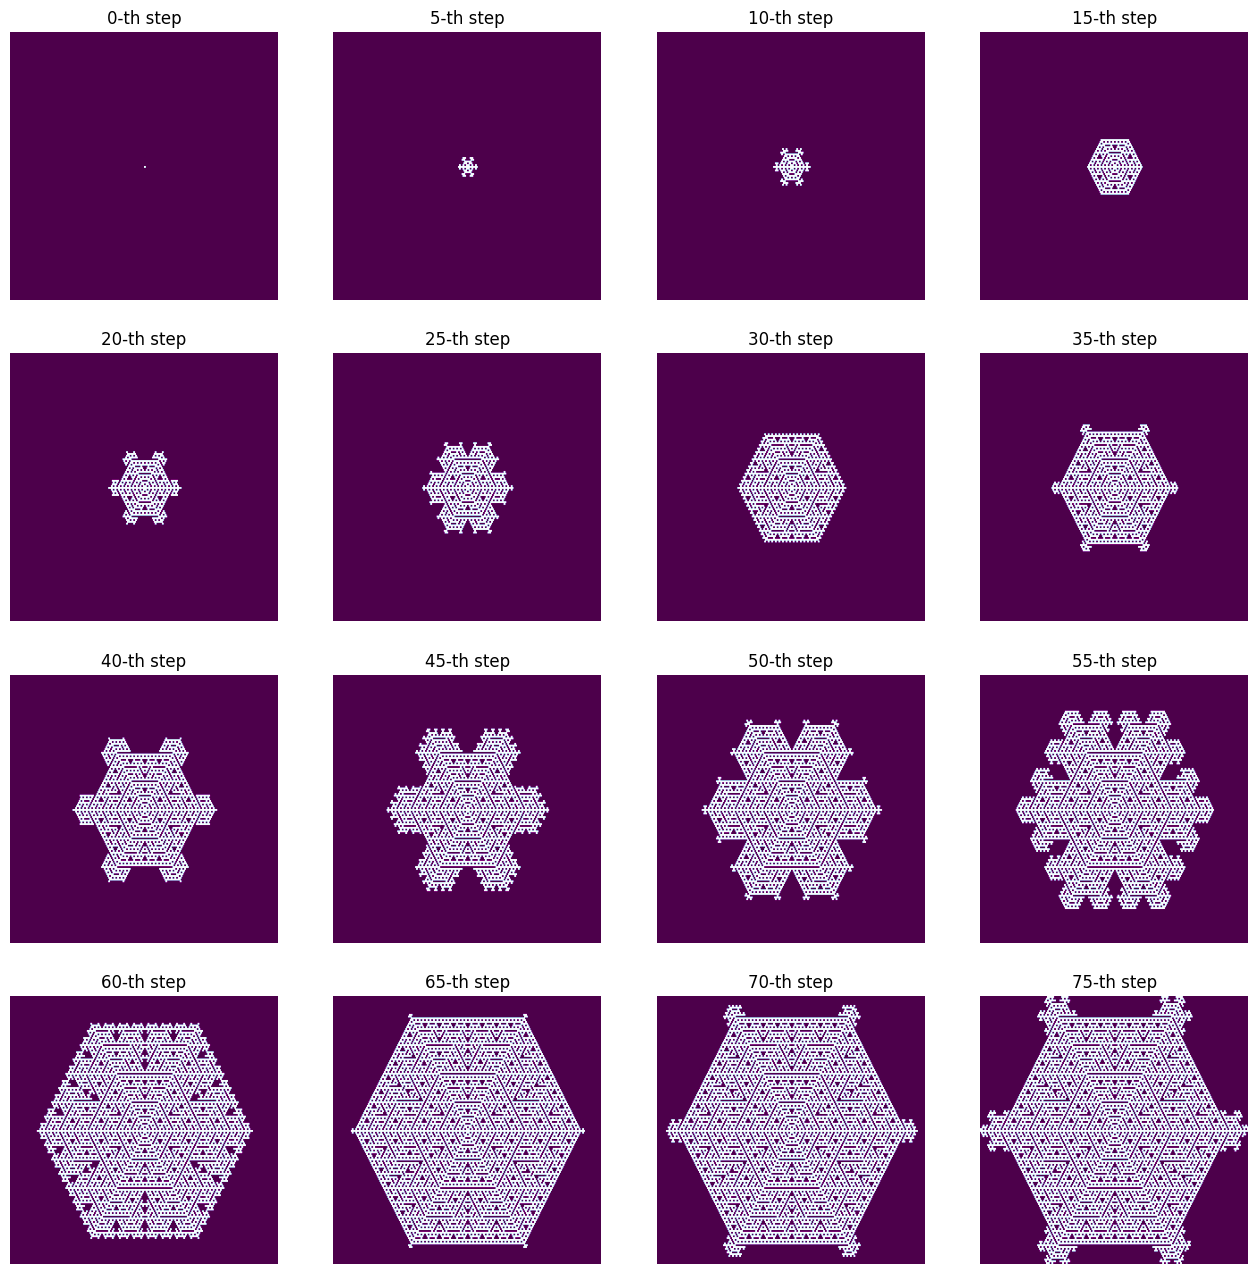

In [17]:
size = 150

grid = np.zeros((size,size))
grid[size//2,size//2] = 1

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i in range(16):
    col, row = i % 4, i // 4
    axes[row, col].imshow((-1)*rescale(grid), cmap="BuPu")
    axes[row, col].set_title(f"{i*5}-th step")
    axes[row, col].axis('off')
    for _ in range(5):
        grid = snowflake(grid,1)
plt.show()

## 3.1

Considering new udpate rule when 2 neighbours are needed to freeze new cell. Starting point is 3x3 frozen square in center.

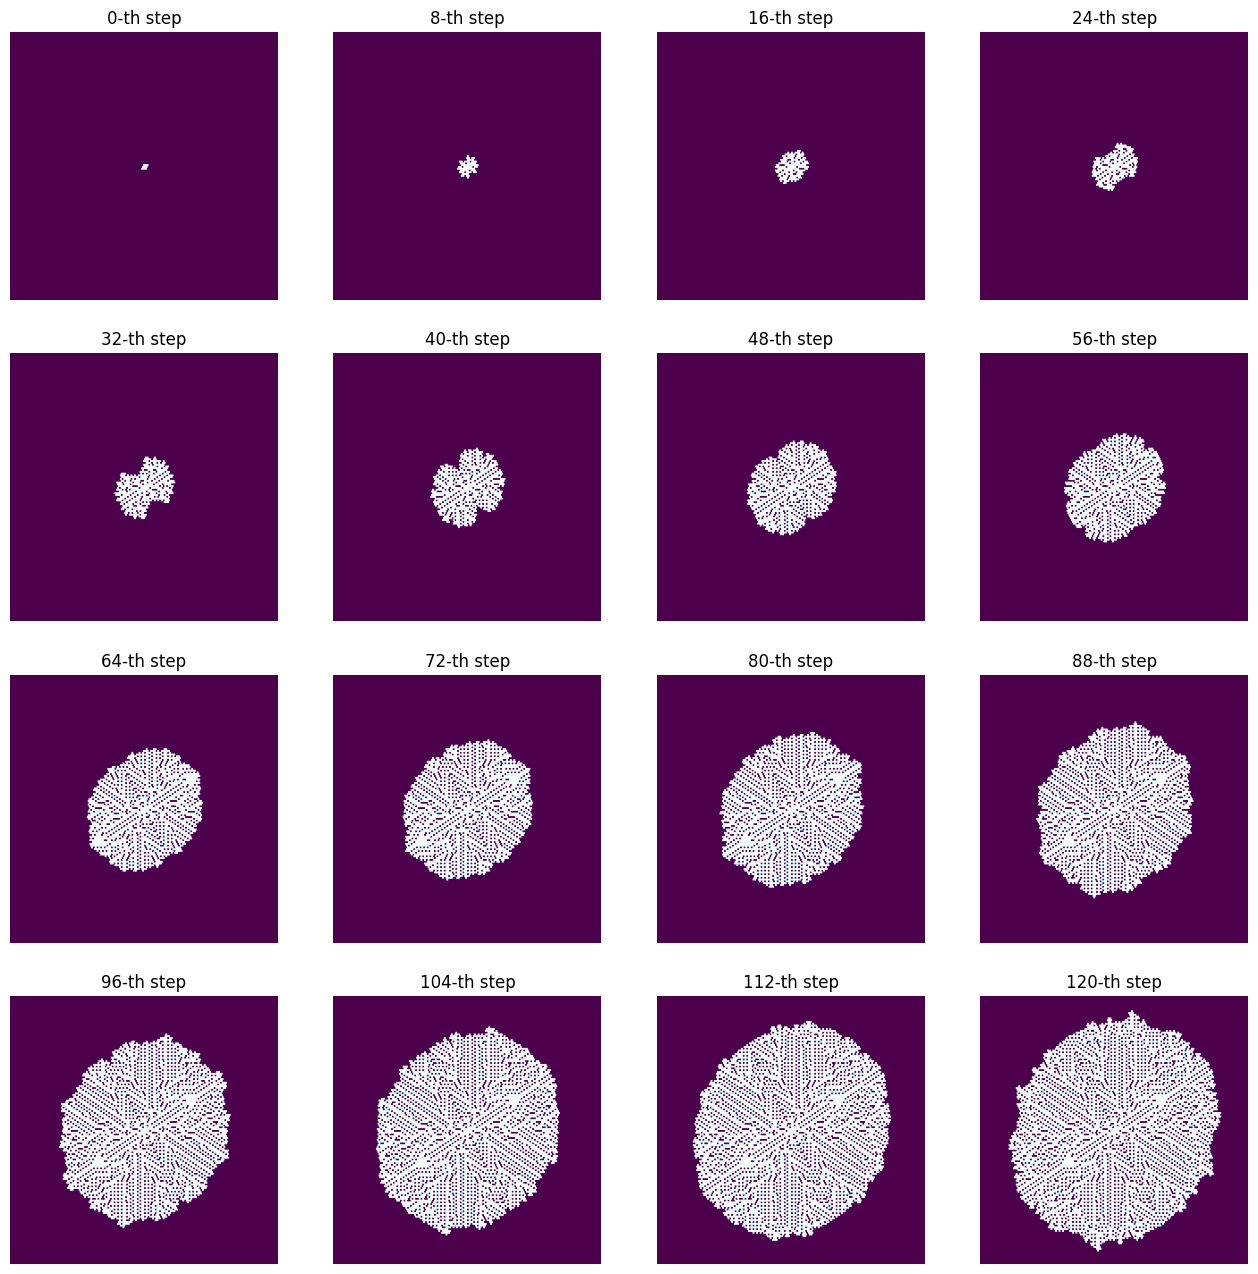

In [18]:
size = 150

grid = np.zeros((size,size))
for i in range(3):
    for j in range(3):
        grid[size//2 - 1 + i,size//2 - 1 + j] = 1

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i in range(16):
    col, row = i % 4, i // 4
    axes[row, col].imshow((-1)*rescale(grid), cmap="BuPu")
    axes[row, col].set_title(f"{i*8}-th step")
    axes[row, col].axis('off')
    for _ in range(8):
        grid = snowflake(grid,2)
plt.show()

## 3.2
New update rule, here any non-zero number of neighbours is needed.

In [19]:
def snowflake_any(grid):
    temp_grid = np.copy(grid)
    for x in range(grid.shape[0]):
        for y in range(grid.shape[0]):
            if grid[x, y] == 0 and count_neighbors(grid, x, y) != 0:
                temp_grid[x, y] = 1
    return temp_grid

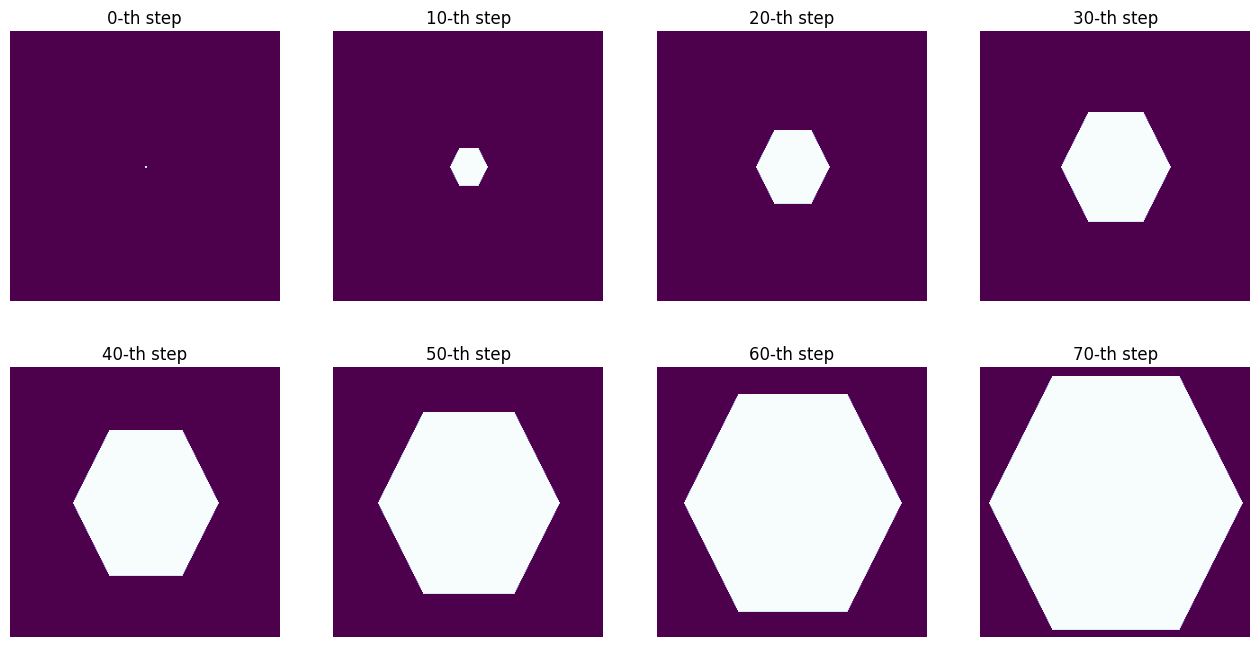

In [20]:
size = 150

grid = np.zeros((size,size))
grid[size//2,size//2] = 1

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(8):
    col, row = i % 4, i // 4
    axes[row, col].imshow((-1)*rescale(grid), cmap="BuPu")
    axes[row, col].set_title(f"{i*10}-th step")
    axes[row, col].axis('off')
    for _ in range(10):
        grid = snowflake_any(grid)
plt.show()

With such assumptions, the automaton built an expanding regular hexagon.

## 3.3
I will perform an additional simulation of the version with one neighbor, but this time the “freezing” will start at three different points instead of one in the center.

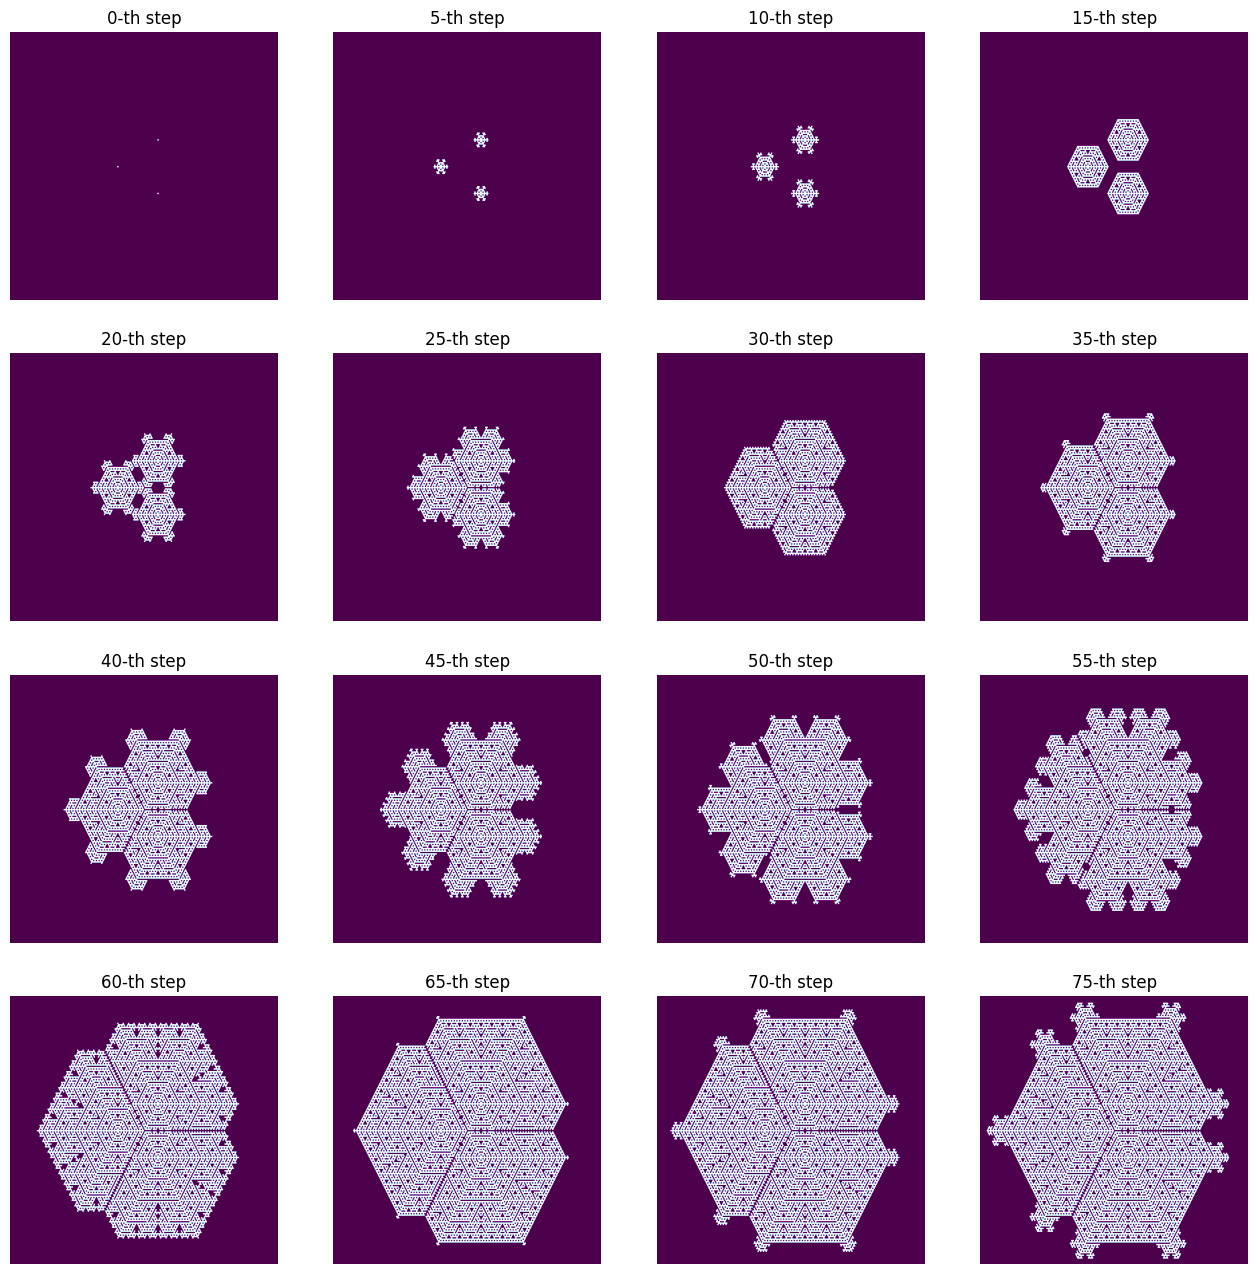

In [21]:
size = 200

grid = np.zeros((size,size))
grid[int(0.4*size),int(0.5*size)] = 1
grid[int(0.6*size),int(0.6*size)] = 1
grid[int(0.5*size),int(0.4*size)] = 1

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i in range(16):
    col, row = i % 4, i // 4
    axes[row, col].imshow((-1)*rescale(grid), cmap="BuPu")
    axes[row, col].set_title(f"{i*5}-th step")
    axes[row, col].axis('off')
    for _ in range(5):
        grid = snowflake(grid,1)
plt.show()

On the boundaries of the freeze coming from each initial point, lines of empty cells were formed, perpendicular to the lines connecting these points.

## 3.4

I will analyze the cases in which one neighbor taken into account in determining the number of neighbors is eliminated each.

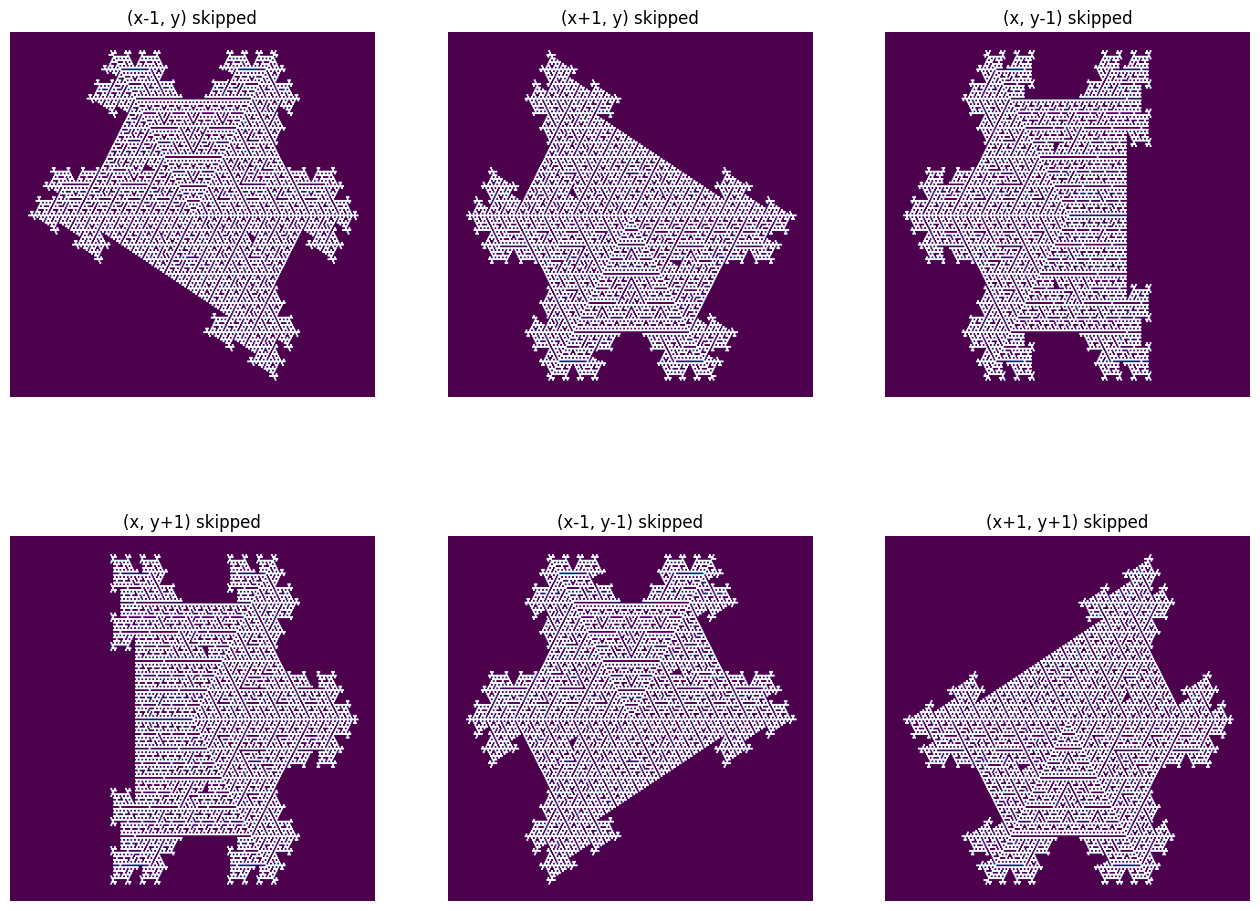

In [22]:
def count_some_neighbors(grid, x, y, delete_id):
    neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1), (x-1, y-1), (x+1, y+1)]
    del neighbors[delete_id] # 'distorted' neighbourhoods
    count = 0
    for neighbor in neighbors:
        nx, ny = neighbor
        if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[0] and grid[nx, ny] == 1:
            count += 1
    return count

def snowflake_test(grid, delete_id):
    temp_grid = np.copy(grid)
    for x in range(grid.shape[0]):
        for y in range(grid.shape[0]):
            if grid[x, y] == 0 and count_some_neighbors(grid, x, y, delete_id) == 1:
                temp_grid[x, y] = 1
    return temp_grid


results = []
size = 200
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
n_str = ["(x-1, y)", "(x+1, y)", "(x, y-1)", "(x, y+1)", "(x-1, y-1)", "(x+1, y+1)"]

for n in range(6):

    grid = np.zeros((size,size))
    grid[size//2,size//2] = 1

    for _ in range(90):
        grid = snowflake_test(grid,n)

    col, row = n % 3, n // 3
    axes[row, col].imshow((-1)*rescale(grid), cmap="BuPu")
    axes[row, col].set_title(f"{n_str[n]} skipped")
    axes[row, col].axis('off')

plt.show()

Such “distortions” of the neighborhood stopped the growth of the snowflake in one direction.